In [1]:
import os
import time
import pandas as pd
import preprocessor as p
from sklearn.cluster import DBSCAN

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

In [3]:
# Remove duplicates
tweets.drop_duplicates(subset="wikidata", inplace=True)

# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Set preprocessor options
p.set_options(p.OPT.URL)

# Remove URLs from the tweets
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

# Order tweets by createdAt
tweets.sort_values(by="createdAt", inplace=True)

In [4]:
# Set index to id for easy matching
tweets.set_index('id', inplace=True, verify_integrity=False)

# Convert lat and long to numpy array
COORDS = tweets[['longitude', 'latitude']].values

In [5]:
# Set DBSCAN parameters
# ? Higher minsamples or lower eps indicate higher density necessary to form a cluster
# ? On noisy and large datasets, higher min_samples is better
EPS = 0.8
MIN_SAMPLES = 5

# Start timer
start = time.time()

# Create DBSCAN model
# ? Noise is labeled -1
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(COORDS)

# End timer
end = time.time()

# Print time taken
print("Time taken: {} seconds".format(end - start))

# Print number of clusters
print("Number of clusters: {}".format(len(set(db.labels_))))

# Store labels in tweets
tweets['cluster'] = db.labels_

Time taken: 0.009999513626098633 seconds
Number of clusters: 5


In [6]:
import geopandas as gpd

# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')

# Convert tweets to geodataframe
tweets_gdf = gpd.GeoDataFrame(
    tweets,
    geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude),
    crs="EPSG:4326"
)

In [7]:
# Read francegeojason file using geopandas
france = gpd.read_file(filename='../data/france.geojson')

In [8]:
# Convert tweets to geodataframe
tweets_gdf = gpd.GeoDataFrame(
    tweets,
    geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude),
    crs="EPSG:4326"
)

Text(0.5, 1.0, 'DBSCAN Clustering of Tweets in France')

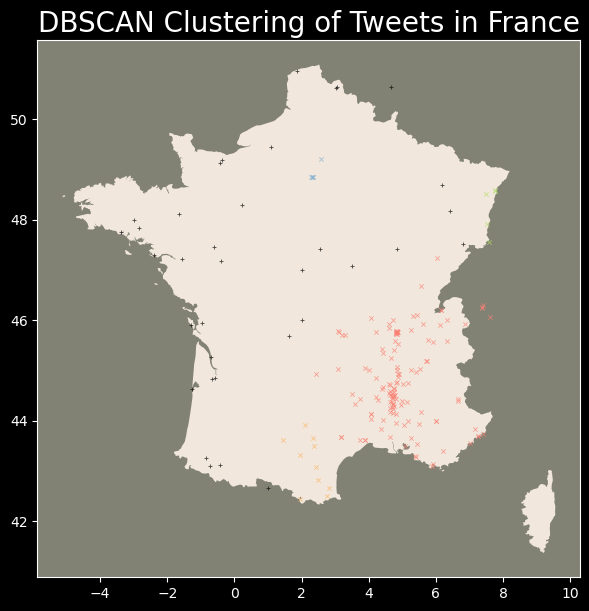

In [9]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')

# Plot tweets with cluster labels with different markers
for cluster in tweets_gdf.cluster.unique():
    tweets_gdf[tweets_gdf.cluster == cluster].plot(
        ax=base,
        markersize=10,
        label='NOISE' if cluster == -1 else 'Cluster {}'.format(cluster),
        alpha=0.7,
        # linewidth=0.6,
        marker='x' if cluster != -1 else '+',
        color='black' if cluster == -1 else 'C{}'.format(cluster + 3),
        linewidth=0.6,
    )

# Set title
base.set_title("DBSCAN Clustering of Tweets in France", fontsize=20)

In [10]:
# Save figure
base.get_figure().savefig('../images/dbscan.png', dpi=300)